In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

from datetime import date
from datetime import datetime
from datetime import timedelta
%matplotlib inline
from matplotlib import pyplot as plt
# import csv
from collections import defaultdict
from decimal import Decimal

## 1. Загрузка данных за май 2016 года.

In [2]:
#%%time
#iter_csv  = pd.readb_csv('yellow_tripdata_2016-05.csv', iterator=True, chunksize=1000)
#df = pd.concat([ chunk[(chunk.tpep_pickup_datetime != chunk.tpep_dropoff_datetime)] for chunk in iter_csv])

In [77]:
# for i, s in enumerate('VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount'.upper().split(',')):
#     print('{} = {}'.format(s, i))


In [74]:
VENDORID = 0
TPEP_PICKUP_DATETIME = 1
TPEP_DROPOFF_DATETIME = 2
PASSENGER_COUNT = 3
TRIP_DISTANCE = 4
PICKUP_LONGITUDE = 5
PICKUP_LATITUDE = 6
RATECODEID = 7
STORE_AND_FWD_FLAG = 8
DROPOFF_LONGITUDE = 9
DROPOFF_LATITUDE = 10
PAYMENT_TYPE = 11
FARE_AMOUNT = 12
EXTRA = 13
MTA_TAX = 14
TIP_AMOUNT = 15
TOLLS_AMOUNT = 16
IMPROVEMENT_SURCHARGE = 17
TOTAL_AMOUNT = 18

In [29]:
%%time
n=0
with open('yellow_tripdata_2016-05.csv') as f:
    for l in csv.reader(f):
#         print(l)
        n+=1
#         if n > 2:
#             break

Wall time: 46.5 s


In [138]:
# datetime.strptime('2016-05-01 00:00:02', '%Y-%m-%d %H:%M:%S')
# s = '2016-05-01 00:00:02'.split(' ')
# list(map(int, s[0].split('-') + s[1].split(':')))
# datetime(*map(int, s[0].split('-') + s[1].split(':')))b
# np.array(['2016-05-01 00:00:02'], dtype=[('123', 'datetime64[s]')])
aline = tuple( ['2016-05-01 00:00:00', '2016-05-01 00:17:31', '1', '3.60', '-73.98590087890625', '40.768039703369141'] )
na = np.array(aline, dtype=[('tpep_pickup_datetime', 'datetime64[s]'),
                       ('tpep_dropoff_datetime', 'datetime64[s]'),
                       ('passenger_count', 'i4'),
                       ('trip_distance', '<f8'),
                       ('pickup_longitude', '<f8'),
                       ('pickup_latitude', '<f8')              ])
na['tpep_pickup_datetime']

array('2016-05-01T00:00:00', dtype='datetime64[s]')

In [142]:
%%time
dtype=[('tpep_pickup_datetime', 'datetime64[s]'),
                               ('tpep_dropoff_datetime', 'datetime64[s]'),
                               ('passenger_count', '<i4'),
                               ('trip_distance', '<f8'),
                               ('pickup_longitude', '<f8'),
                               ('pickup_latitude', '<f8') ]
n = 0
with open('yellow_tripdata_2016-05-01.csv', 'rb') as f:
    next(f)
    for line in f:
        aline = str(line).split(',')[1:PICKUP_LATITUDE+1]
#         print(aline)
        na = np.array(tuple(aline), dtype=dtype)
        if  na['tpep_pickup_datetime'] < na['tpep_dropoff_datetime'] and \
            na['passenger_count']  > 0  and \
            na['trip_distance'] > 0. and \
            na['pickup_longitude'] >= coord_NY[0][0] and \
            na['pickup_longitude'] <= coord_NY[1][0] and \
            na['pickup_latitude'] >= coord_NY[0][1] and \
            na['pickup_latitude'] <= coord_NY[1][1] :
            n+=1
#         print(sa)
#         break
        
print(n)        

375250
Wall time: 7.62 s


Вариант с разбором через структурированный массив np.array почти в два раза худшее время

In [150]:
%%time
n = 0
with open('yellow_tripdata_2016-05-01.csv', 'rb') as f:
    next(f)
    for line in f:
        aline = str(line).split(',')
        pickup_longitude = float(aline[PICKUP_LONGITUDE])
        pickup_latitude  = float(aline[PICKUP_LATITUDE])
#         tpep_pickup_datetime = datetime.strptime(aline[TPEP_PICKUP_DATETIME], '%Y-%m-%d %H:%M:%S')
#         s = aline[TPEP_PICKUP_DATETIME].split(' ')
#         tpep_pickup_datetime = datetime(*map(int, s[0].split('-') + s[1].split(':')))
#         s = aline[TPEP_DROPOFF_DATETIME].split(' ')
#         tpep_dropoff_datetime = datetime(*map(int, s[0].split('-') + s[1].split(':'))) 
        # применение np.datetime64 улучшило на 0.9 секунды скорость по сравнению с 
        # вариантом split
        tpep_pickup_datetime = np.datetime64(aline[TPEP_PICKUP_DATETIME])
        tpep_dropoff_datetime = np.datetime64(aline[TPEP_DROPOFF_DATETIME])
        passenger_count = int(aline[PASSENGER_COUNT])
        trip_distance = float(aline[TRIP_DISTANCE])
        
        if  tpep_pickup_datetime < tpep_dropoff_datetime and \
                passenger_count  > 0  and \
                trip_distance > 0. and \
                pickup_longitude >= coord_NY[0][0] and \
                pickup_longitude <= coord_NY[1][0] and \
                pickup_latitude >= coord_NY[0][1] and \
                pickup_latitude <= coord_NY[1][1] :
            n+=1
#         print(pickup_longitude, pickup_latitude, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance)
#         break
            
print(n)
# 375250

11626521
Wall time: 2min 4s


In [106]:
pickup_latitude <= coord_NY[1][1]

True

In [4]:
print(n)

11836854


In [157]:
%%time
#df  = pd.read_csv('yellow_tripdata_2016-05.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
chunksize = 2* 10 ** 6
for df in pd.read_csv('yellow_tripdata_2016-05.csv', chunksize=chunksize):
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df.drop(df[
        (df.tpep_pickup_datetime == df.tpep_dropoff_datetime)  |
        (df.passenger_count <= 0)   | 
        (df.trip_distance <= 0.) |
        (df.pickup_longitude < coord_NY[0][0]) |
        (df.pickup_longitude > coord_NY[1][0]) |
        (df.pickup_latitude < coord_NY[0][1]) |
        (df.pickup_latitude > coord_NY[1][1])
    ].index, inplace = True)

Wall time: 1min 9s


In [7]:
print(df.shape)
df.head()

(382101, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [69]:
#Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы (longitude)
# и от 40.49612 до 40.91553 широты (lattitude). 
#Географическая широта – длина дуги в градусах от экватора до заданной точки
#Географическая долгота – длина дуги экватора в градусах от начального меридиана
#(0 градусов) до меридиана заданной точки
coord_NY = ((-74.25559, 40.49612), (-73.70001,  40.91553))

In [9]:
coord_NY[1][0]

-73.70001

## 2. Проведение фильтрации

Удаление поезок с:
- нулевой длительностью
- нулевым количеством пассажиров
- нулевым расстоянием поездки по счётчику
- координатами начала, не попадающими в прямоугольник Нью-Йорка

In [10]:
%%time
df.drop(df[
    (df.tpep_pickup_datetime == df.tpep_dropoff_datetime)  |
    (df.passenger_count <= 0)   | 
    (df.trip_distance <= 0.) |
    (df.pickup_longitude < coord_NY[0][0]) |
    (df.pickup_longitude > coord_NY[1][0]) |
    (df.pickup_latitude < coord_NY[0][1]) |
    (df.pickup_latitude > coord_NY[1][1])
].index, inplace = True)
print(df.shape)

(375250, 19)
Wall time: 221 ms


При выполнении на первом дне мая получилось (375250, 19)

In [11]:
%%time
#Если с самого начала (при считывании данных) задать разбор в дату
#parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'] то удаление
#выполняется в течении 5 минут. Кроме того, и загрузка занимает более 2 минут.

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

Wall time: 1.02 s


## 3. Агрегирование данных за май 2016

In [12]:
dBeg = datetime.combine(df.tpep_pickup_datetime.min().date(), datetime.min.time()) 
dEnd = datetime.combine(df.tpep_pickup_datetime.max().date(), datetime.max.time()) 

In [13]:
print(dBeg, dEnd)

2016-05-01 00:00:00 2016-05-01 23:59:59.999999


In [14]:
d = [dBeg + timedelta(hours=x) for x in range(0, 24*((dEnd - dBeg).days + 1))]


In [15]:
d = [dBeg + timedelta(hours=x) for x in range(0, 2)]
dft = df[(df.tpep_pickup_datetime >= d[0]) & (df.tpep_pickup_datetime <= d[1])]

In [16]:
dft[['pickup_longitude','pickup_latitude']].values

array([[-73.98590088,  40.7680397 ],
       [-73.99157715,  40.74475098],
       [-73.99307251,  40.74157333],
       ...,
       [-73.99010468,  40.73094177],
       [-73.7817688 ,  40.64464951],
       [-73.98171997,  40.76887894]])

In [4]:
dfGrid = pd.read_csv('regions.csv', sep=';') 

dfGrid.head(10)
#west - запад, east - восток
dfGrid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
region    2500 non-null int64
west      2500 non-null float64
east      2500 non-null float64
south     2500 non-null float64
north     2500 non-null float64
dtypes: float64(4), int64(1)
memory usage: 97.7 KB


In [18]:
#%%time
#посчитаем вручную количество (для последующей сверки с данными binned_statistic_2d)
dfGrid['Count'] = 0
for longitude, latitude in dft[['pickup_longitude','pickup_latitude']].values:
    #print(longitude, latitude)
    l = dfGrid[ 
        (dfGrid.west < longitude) & (dfGrid.east >= longitude) &
        (dfGrid.south < latitude) & (dfGrid.north >= latitude)
    ].index.values
    if len(l) != 1:
        print("len(l) == {}", len(l))
    dfGrid.loc[l,'Count'] = dfGrid.loc[l,'Count'] + 1
    #print(longitude, latitude, l[0])
    #print(dfGrid.loc[l])


In [19]:
print (sum(dfGrid.Count.values))
dfGrid[dfGrid.Count != 0].head(10)

23989


,region,west,east,south,north,Count
1014,1015,-74.033358,-74.022246,40.613555,40.621943,1
1016,1017,-74.033358,-74.022246,40.630331,40.638719,1
1028,1029,-74.033358,-74.022246,40.730990,40.739378,3
1029,1030,-74.033358,-74.022246,40.739378,40.747766,1
1032,1033,-74.033358,-74.022246,40.764542,40.772931,4
1067,1068,-74.022246,-74.011135,40.638719,40.647108,1
1071,1072,-74.022246,-74.011135,40.672272,40.680660,4
1074,1075,-74.022246,-74.011135,40.697437,40.705825,71
1075,1076,-74.022246,-74.011135,40.705825,40.714213,64
1076,1077,-74.022246,-74.011135,40.714213,40.722601,52


In [20]:
dfGrid.shape

(2500, 6)

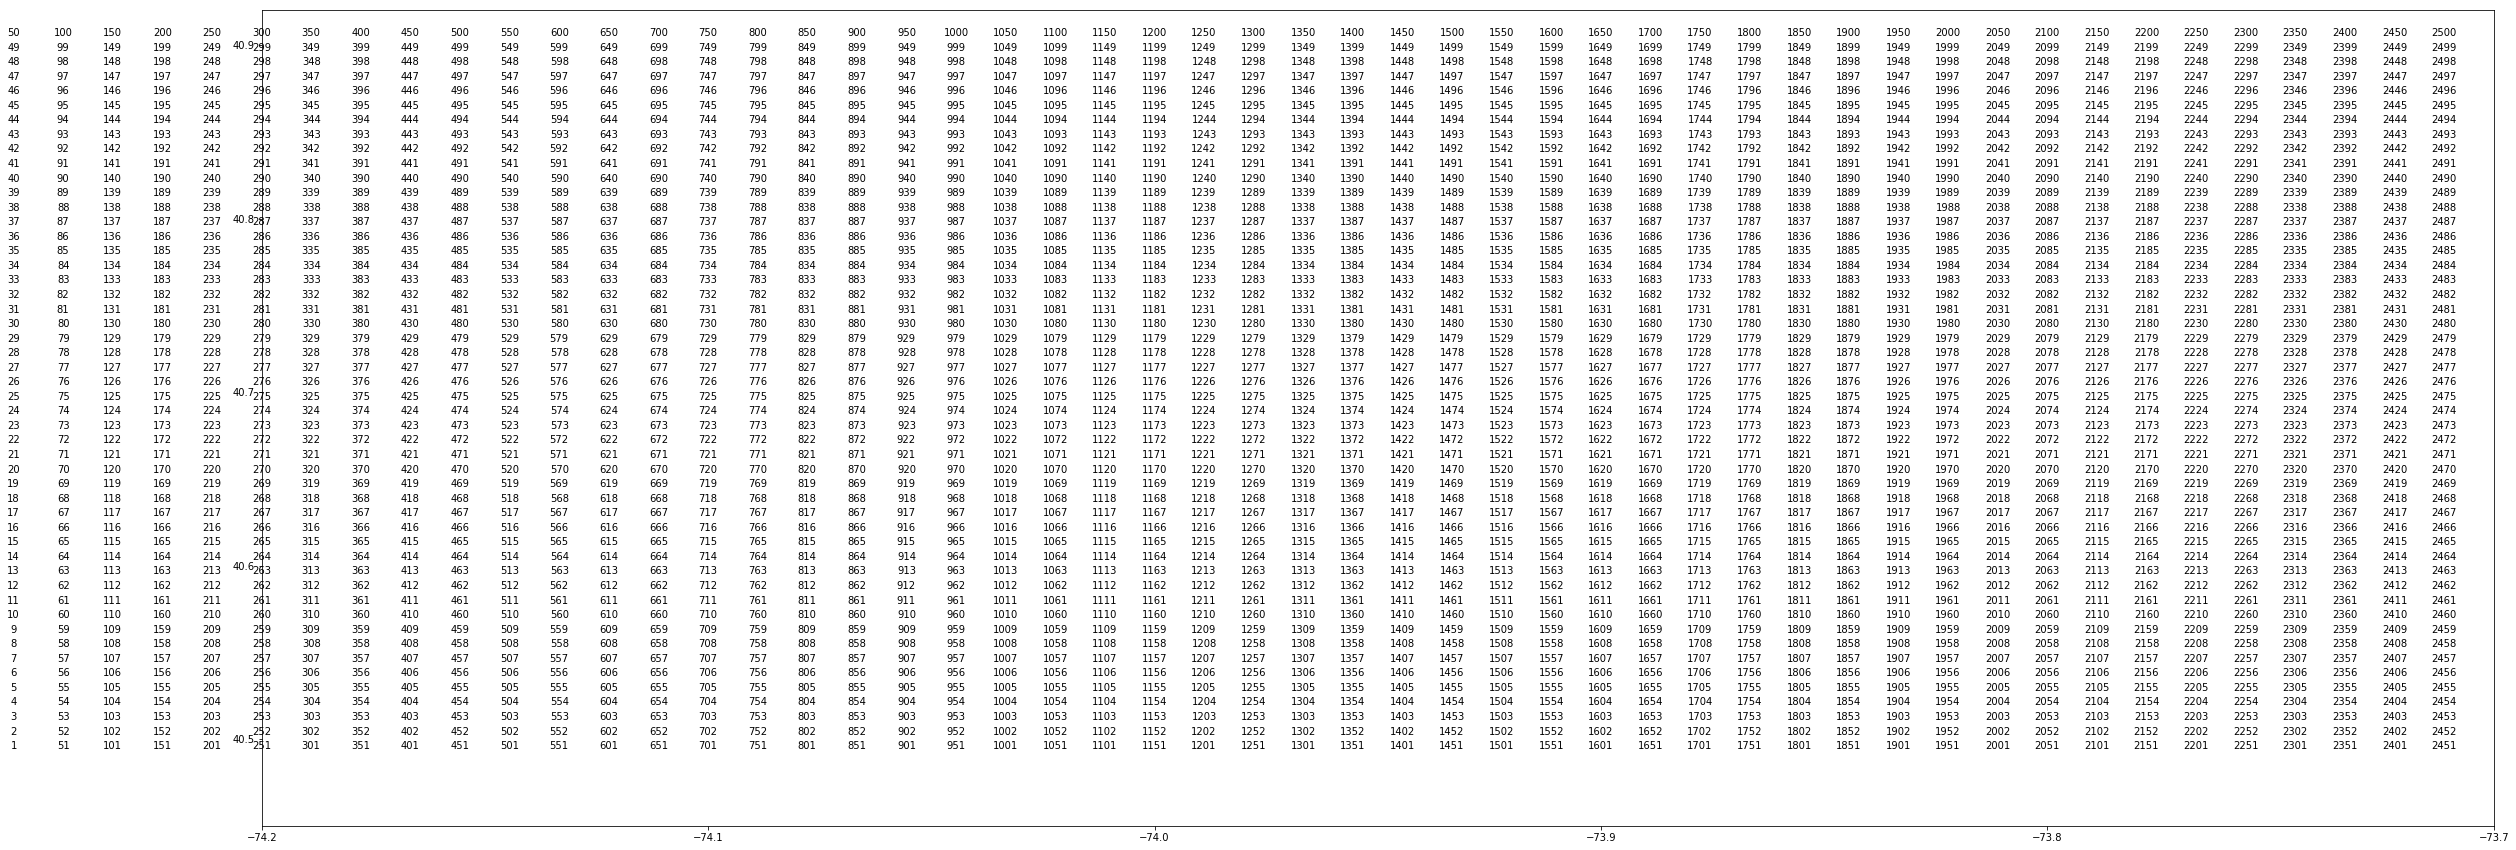

In [20]:

fig = plt.figure(figsize = (40,15))
ax=plt.subplot(111)
for region, i, j in dfGrid[['region','west','south']].values:
    ax.text( i, j, '{:.0f}'.format(region), ha='center', va='center')
plt.xlim(-74.20, -73.70)
plt.ylim(40.45, 40.92)
plt.show()

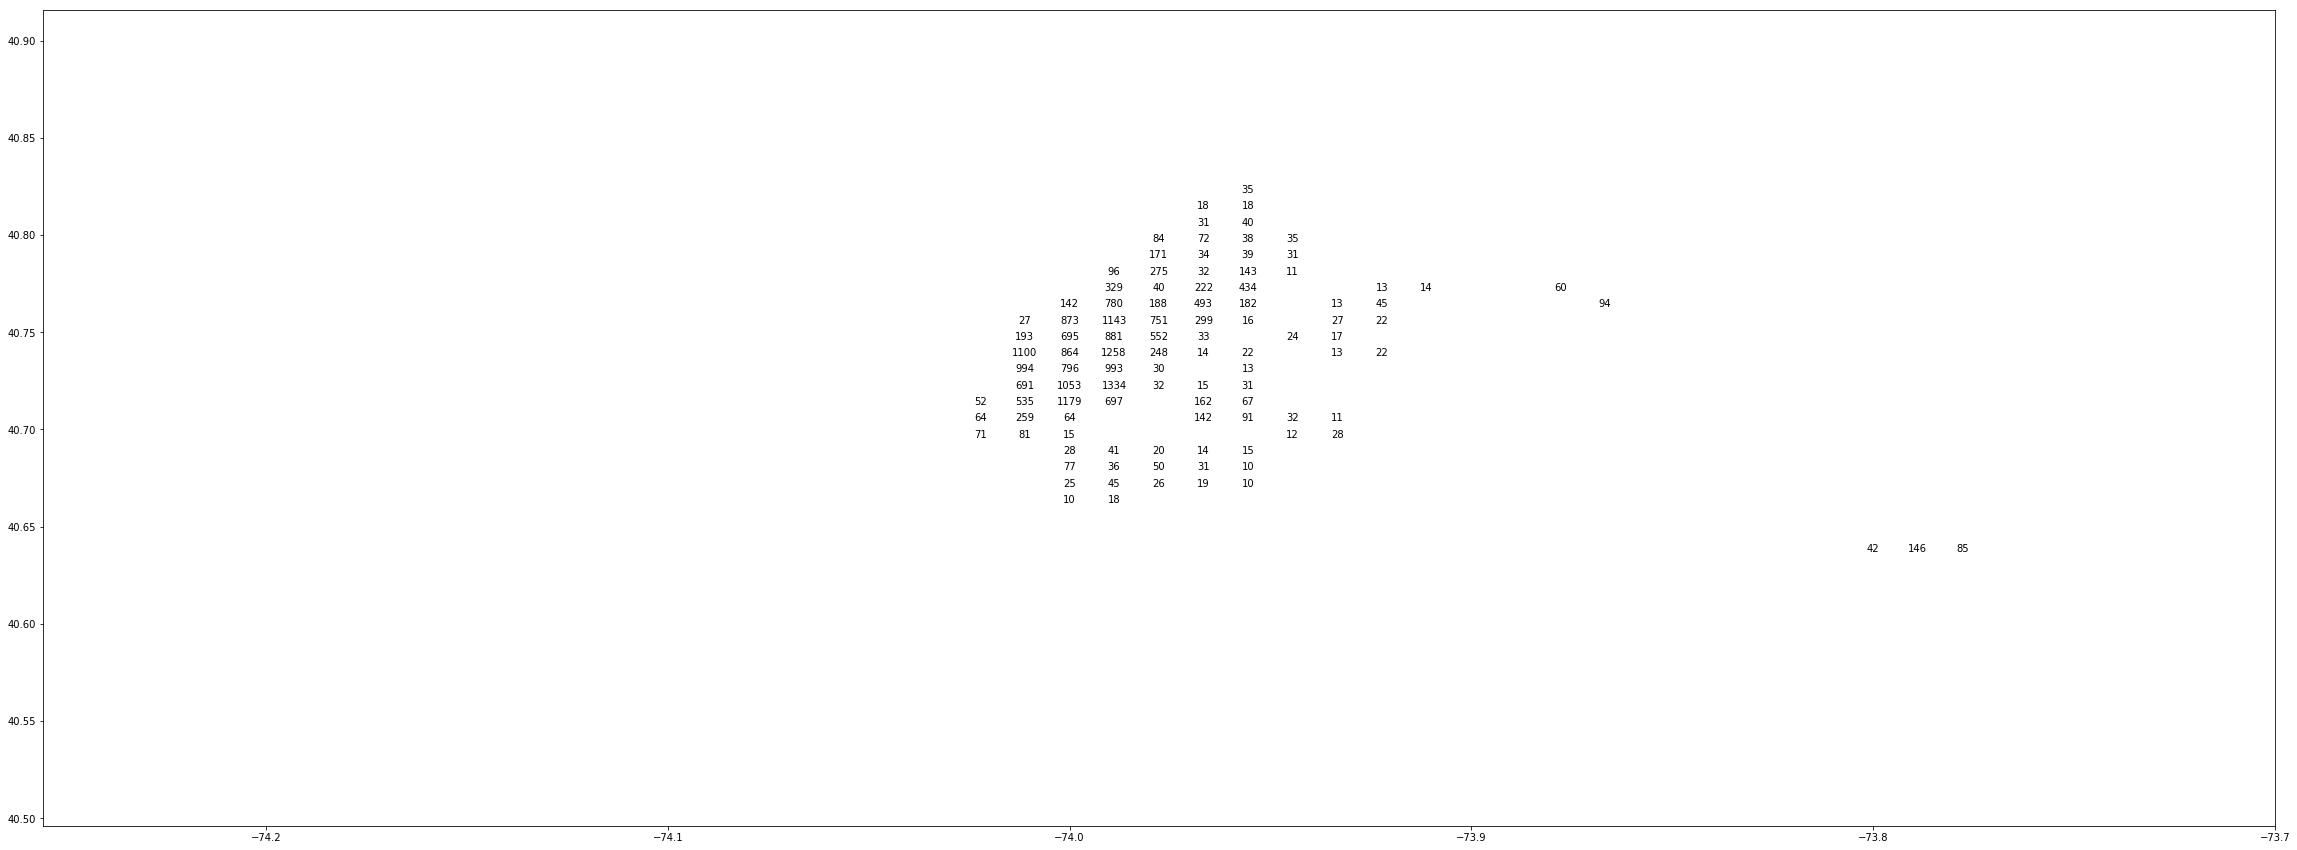

In [57]:
fig = plt.figure(figsize = (40,15))
ax=plt.subplot(111)
for count, i, j in dfGrid[['Count','west','south']].values:
    if count >= 10:
        ax.text( i, j, '{:.0f}'.format(count), ha='center', va='center')
plt.xlim(dfGrid.west.min(), dfGrid.east.max())
plt.ylim(dfGrid.south.min(), dfGrid.north.max())
plt.show()

In [79]:
dfGrid.re

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [83]:
dfOut = pd.DataFrame( [dfGrid.Count.tolist()], 
            columns=  ['reg{}'.format(x) for x in np.unique(dfGrid.region.values)] )

In [86]:
dfOut.reg1075

0    71
Name: reg1075, dtype: int64

In [106]:
H2, xedges2, yedges2, binnumber2 = stats.binned_statistic_2d(
    dft['pickup_longitude'],
    dft['pickup_latitude'], 
    None,
    bins = [np.append(np.unique(dfGrid.west.values),  [dfGrid.east.max()]), 
            np.append(np.unique(dfGrid.south.values),  [dfGrid.north.max()])],           
    statistic='count' )

In [107]:
H2.shape
#H2 = H2.T

(50, 50)

In [108]:
l = H2.ravel()
print(len(l))
for i, j in zip(dfGrid.Count.tolist(), l):
    if i != j:
        print(i, j)

2500


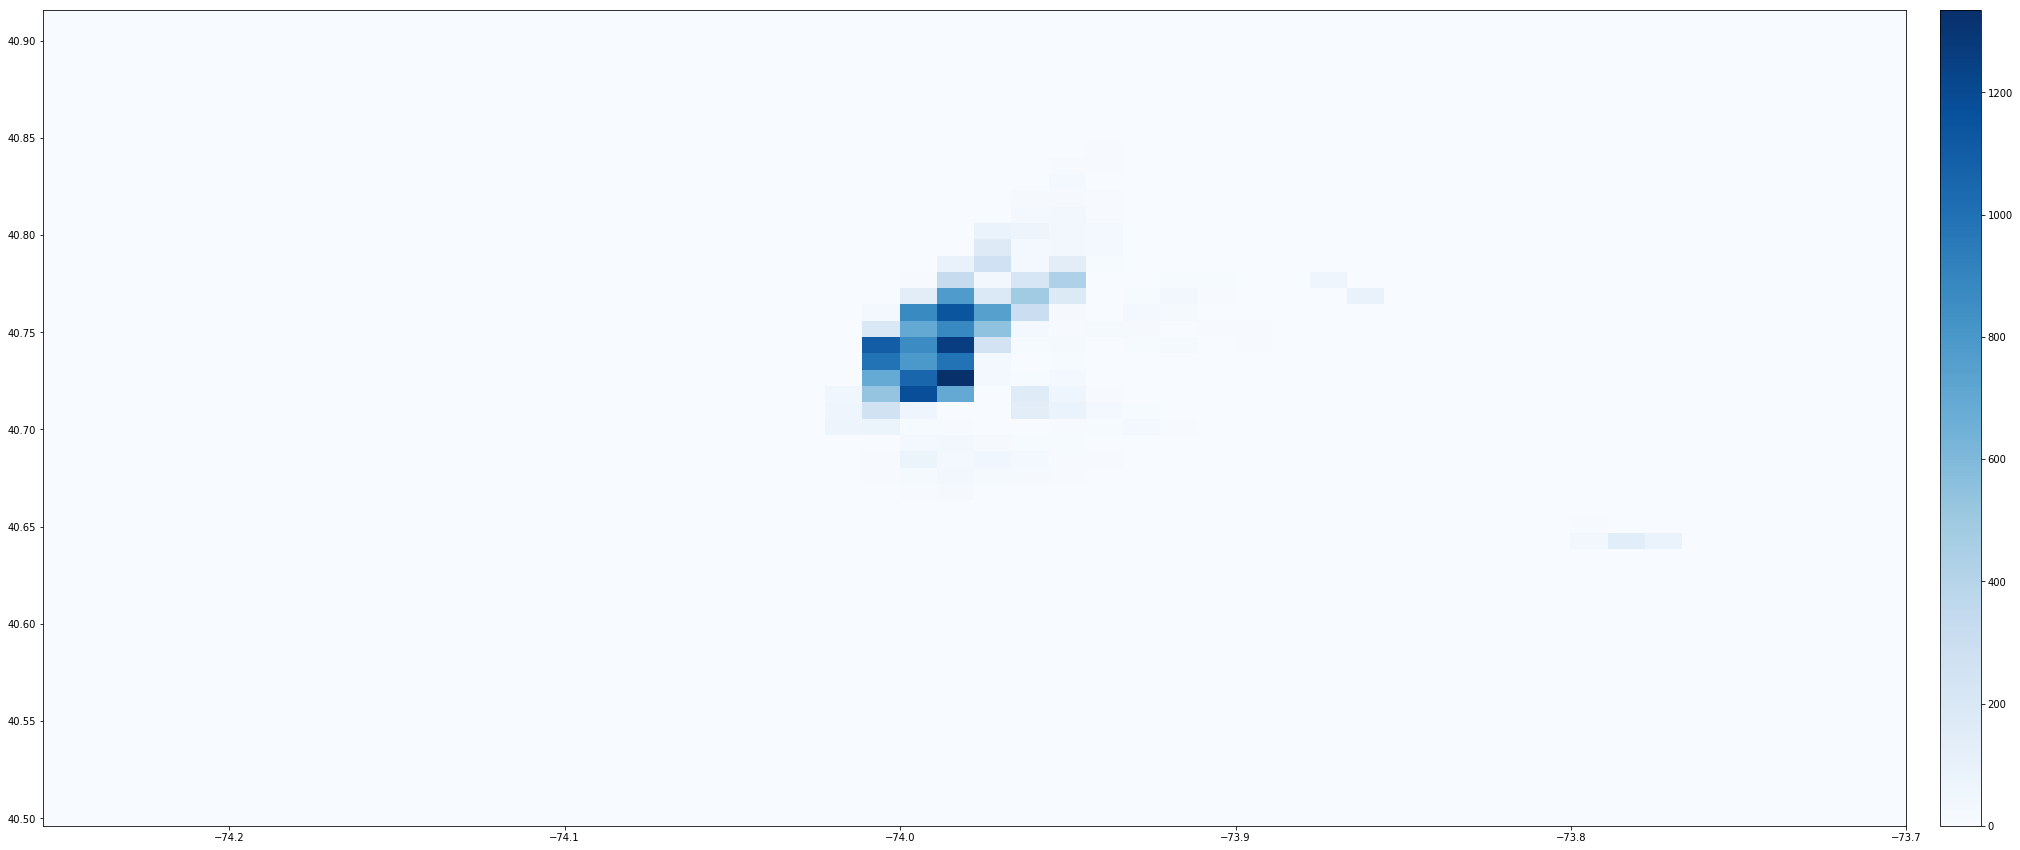

In [68]:
XX, YY = np.meshgrid(xedges2, yedges2)
fig = plt.figure(figsize = (40,15))
ax1=plt.subplot(111)
plot1 = ax1.pcolormesh(XX,YY,H2,cmap=plt.get_cmap("Blues"))
cbar = plt.colorbar(plot1,ax=ax1, pad = .015, aspect=20)
plt.show()

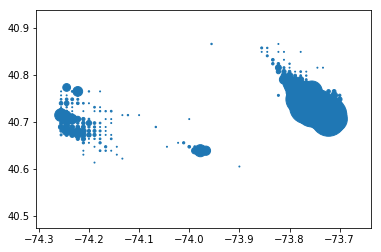

In [58]:
plt.scatter( XX, YY, H2)

In [5]:
def coord_str_to_int(scoord):
    ipos = scoord.find('.')
    if ipos >= 0:
        ret = int(scoord.replace('.', '').ljust(15 + ipos, '0'))
    else:
        ret = 0
    
    return ret

def coord_to_region(west, south, x_min, t_min, step_X, ncolumns):
    return int(((west - x_min)  // step_X)* ncolumns + ( south - y_min) // step_Y + 1)

In [6]:
s = '4.2444784'
float(s.ljust(16 + s.find('.'), '0'))


4.2444784

In [ ]:
# https://beta.rstudioconnect.com/content/2211/taxi01.html
# Данные для проверки по поездкам из квадрата 
# так можно узнать координаты Empire State Building
# ESB <- as.list(geocode('Empire State Building'))

# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="my_app app") 
# location = geolocator.geocode("Empire State Building'")
# print(location.address)
# print((location.latitude, location.longitude))
# >>>Empire State Building, 350, 5th Avenue, Korea Town, Midtown South, 
# >>>Manhattan Community Board 5, Manhattan, New York County, NYC, New York, 10018, USA
# >>>(40.7484284, -73.9856546198733)



# на случай, если нет подключения, введем координаты вручную
# ESB <- list(lon = -73.98566, lat = 40.74844)
##      year month day hour region    n                date
##   1: 2016     5   1    0   1231  881 2016-05-01 00:00:00
##   2: 2016     5   1    1   1231  713 2016-05-01 01:00:00
##   3: 2016     5   1    2   1231  533 2016-05-01 02:00:00
##   4: 2016     5   1    3   1231  418 2016-05-01 03:00:00
##   5: 2016     5   1    4   1231  353 2016-05-01 04:00:00
##  ---                                                    
## 740: 2016     5  31   19   1231 1094 2016-05-31 19:00:00
## 741: 2016     5  31   20   1231  997 2016-05-31 20:00:00
## 742: 2016     5  31   21   1231 1099 2016-05-31 21:00:00
## 743: 2016     5  31   22   1231  874 2016-05-31 22:00:00
## 744: 2016     5  31   23   1231  608 2016-05-31 23:00:00

In [3]:
from decimal import Decimal


def decimal_from_value(value):
    return Decimal(value)

# df = pd.read_csv(filename, converters={'sales': decimal_from_value})

dfGrid = pd.read_csv('regions.csv', sep=';', converters={
                    'west': decimal_from_value,
                    'east': decimal_from_value,
                    'south': decimal_from_value,
                    'north': decimal_from_value }) #, float_precision='high' )

# dfGrid = pd.read_csv('regions.csv', sep=';', dtype='str') #, float_precision='high' )
# , dtype = {'region':'int', 
#         'west':'float64', 'east': 'float64', 'south':'float64', 'north':'float64'})

# , dtype = {'region':'int', 
#         'west':'float64', 'east': 'float64', 'south':'float64', 'north':'float64'})
# dfGrid = dfGrid.round(6)
# dfGrid.head(10)
#west - запад, east - восток
# dfGrid.info()
# print(dfGrid.diff().min())
# print(dfGrid.diff().max())
# # dfGrid.diff()

# for f in ['west', 'east', 'south', 'north']:
#     print(f,  dfGrid[f].map(lambda x: len(x) - x.index('.')).max())  
# dfGrid['region'] = dfGrid['region'].apply(lambda s: int(s))
# for f in ['west', 'east', 'south', 'north']:
# #     dfGrid[f] = dfGrid[f].apply(lambda s: coord_str_to_int(s))
#     dfGrid[f] = dfGrid[f].apply(lambda s: float(s.ljust(15 + s.find('.'), '0')+'1'))

dfGrid.head()

,region,west,east,south,north
0,1,-74.25559,-74.2444784,40.49612,40.5045082
1,2,-74.25559,-74.2444784,40.5045082,40.5128964
2,3,-74.25559,-74.2444784,40.5128964,40.5212846
3,4,-74.25559,-74.2444784,40.5212846,40.5296728
4,5,-74.25559,-74.2444784,40.5296728,40.538061


In [6]:
# pd.set_option('precision', 6)
# dfGrid = pd.read_csv('regions.csv', sep=';', float_precision='round_trip') #, dtype='str') # , float_precision='round_trip')
for f in ['west', 'east', 'south', 'north']:
    dfGrid[f] = dfGrid[f].apply(float)

dfGrid['step_X'] = dfGrid.east - dfGrid.west
dfGrid['step_Y'] = dfGrid.north - dfGrid.south
ncolumns = len(dfGrid.east.unique())
x_min = dfGrid.west.min() 
y_min = dfGrid.south.min() 
step_Y = dfGrid['step_Y'].max()
step_X = dfGrid['step_X'].max()
dfGrid['test'] = dfGrid.apply(lambda r: coord_to_region(r['west'], r['south'], x_min, y_min, step_X, ncolumns),
                              axis=1)


In [7]:
print(dfGrid['step_Y'].unique())
print(dfGrid['step_X'].unique())
[str(x) for x in dfGrid['step_Y'].unique()]

[0.0083882 0.0083882]
[0.0111116 0.0111116]


['0.008388199999998847', '0.008388200000005952']

In [12]:
# dfGrid.head(20)
dfGrid[dfGrid.region != dfGrid.test]
# dfGrid[ ( dfGrid.region > 195 )  &  (dfGrid.region < 210)]

,region,west,east,south,north,step_X,step_Y,test


In [26]:
dfGrid.head()

,region,west,east,south,north,step_X,step_Y,test
0,1,-74.25559,-74.2444784,40.49612,40.5045082,0.0111116,0.0083882,1
1,2,-74.25559,-74.2444784,40.5045082,40.5128964,0.0111116,0.0083882,2
2,3,-74.25559,-74.2444784,40.5128964,40.5212846,0.0111116,0.0083882,3
3,4,-74.25559,-74.2444784,40.5212846,40.5296728,0.0111116,0.0083882,4
4,5,-74.25559,-74.2444784,40.5296728,40.538061,0.0111116,0.0083882,5


Расчет в ручном режиме количества попаданий в каждый квадрат. Выполняем на основе словаря.

In [2]:

#Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы (longitude)
# и от 40.49612 до 40.91553 широты (lattitude). 
#Географическая широта – длина дуги в градусах от экватора до заданной точки
#Географическая долгота – длина дуги экватора в градусах от начального меридиана
#(0 градусов) до меридиана заданной точки
coord_NY = ((coord_str_to_int('-74.25559'), coord_str_to_int('40.49612')), 
            (coord_str_to_int('-73.70001'), coord_str_to_int('40.91553')))

NameError: name 'coord_str_to_int' is not defined

In [62]:
%%time
d_count = defaultdict(lambda:0)
#df  = pd.read_csv('yellow_tripdata_2016-05.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
chunksize = 2* 10 ** 6
for df in pd.read_csv('yellow_tripdata_2016-05-01.csv', chunksize=chunksize, dtype='str'):
    
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['passenger_count'] = df['passenger_count'].apply(lambda s: int(s))
    df['trip_distance'] = df['trip_distance'].apply(lambda s: float(s))    
    
#     for f in ['pickup_longitude', 'pickup_longitude', 'pickup_latitude', 'pickup_latitude']:
    for f in ['pickup_longitude', 'pickup_latitude']:
        df[f] = df[f].apply(lambda s: coord_str_to_int(s))

    df.drop(df[
        (df.tpep_pickup_datetime == df.tpep_dropoff_datetime)  |
        (df.passenger_count <= 0)   | 
        (df.trip_distance <= 0.) |
        (df.pickup_longitude < coord_NY[0][0]) |
        (df.pickup_longitude > coord_NY[1][0]) |
        (df.pickup_latitude < coord_NY[0][1]) |
        (df.pickup_latitude > coord_NY[1][1])
    ].index, inplace = True)
    df['count'] = df.apply(lambda r:coord_to_region(r['pickup_longitude'], r['pickup_latitude'], x_min, y_min, step_X, ncolumns), 
                           axis = 1)
    for i in  df['count'].values:
        d_count[i] += 1

Wall time: 5.44 s


In [60]:
d_count

defaultdict(<function __main__.<lambda>()>,
            {1233: 11764,
             1180: 13719,
             1173: 510,
             1130: 12522,
             1231: 13851,
             1234: 9041,
             1384: 10001,
             1228: 11489,
             1183: 2504,
             2118: 3628,
             1281: 11886,
             1227: 6502,
             1128: 7355,
             1178: 12716,
             1285: 6228,
             1333: 9635,
             1229: 11301,
             1182: 10888,
             1129: 9870,
             1232: 17610,
             1230: 14756,
             1179: 11308,
             1181: 18442,
             1286: 5162,
             1127: 5793,
             1326: 841,
             1385: 4840,
             1280: 3848,
             1274: 221,
             1177: 10002,
             1376: 531,
             1126: 3464,
             1282: 15785,
             2168: 2062,
             1125: 971,
             1131: 3562,
             1077: 1434,
             1437: 7

In [91]:
%%time


#Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы (longitude)
# и от 40.49612 до 40.91553 широты (lattitude). 
#Географическая широта – длина дуги в градусах от экватора до заданной точки
#Географическая долгота – длина дуги экватора в градусах от начального меридиана
#(0 градусов) до меридиана заданной точки
coord_NY = ((-74.25559, 40.49612), (-73.70001,  40.91553))
aout = np.zeros([50, 50])
d_count = defaultdict(lambda:0)
#df  = pd.read_csv('yellow_tripdata_2016-05.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
chunksize = 10 ** 6
for df in pd.read_csv('yellow_tripdata_2016-05.csv', 
                      converters={ 
                          'pickup_longitude': decimal_from_value,
                          'pickup_latitude': decimal_from_value,
                          'tpep_pickup_datetime': pd.to_datetime,  
                          'tpep_pickup_datetime': pd.to_datetime,  
                      },
                      chunksize=chunksize):
    
#     df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
#     df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
#     df['passenger_count'] = df['passenger_count'].apply(lambda s: int(s))
#     df['trip_distance'] = df['trip_distance'].apply(lambda s: float(s))    
    
#     for f in ['pickup_longitude', 'pickup_longitude', 'pickup_latitude', 'pickup_latitude']:
#     for f in ['pickup_longitude', 'pickup_latitude']:
#         df[f] = df[f].apply(lambda s: coord_str_to_int(s))

    df.drop(df[
        (df.tpep_pickup_datetime == df.tpep_dropoff_datetime)  |
        (df.passenger_count <= 0)   | 
        (df.trip_distance <= 0.) |
        (df.pickup_longitude < coord_NY[0][0]) |
        (df.pickup_longitude > coord_NY[1][0]) |
        (df.pickup_latitude < coord_NY[0][1]) |
        (df.pickup_latitude > coord_NY[1][1])
    ].index, inplace = True)
    df['count'] = df.apply(lambda r:coord_to_region(r['pickup_longitude'], r['pickup_latitude'], x_min, y_min, step_X, ncolumns), 
                           axis = 1)
    for i in  df['count'].values:
        d_count[i] += 1
        
        
        
    H2, xedges2, yedges2, binnumber2 = stats.binned_statistic_2d(
        df['pickup_longitude'].astype(float), df['pickup_latitude'].astype(float), 
        None,
        bins = [np.append(np.unique(dfGrid.west.values),  [dfGrid.east.max()]).astype(float), 
                np.append(np.unique(dfGrid.south.values),  [dfGrid.north.max()]).astype(float)],
        statistic='count' )
    aout = aout + H2
#     break
    

KeyboardInterrupt: 

In [88]:
d_count[1231]

14117

In [89]:
aout[24, 30]

14117.0

In [90]:
n_ok = 0
for x in range(0, 50):
    for y in range(0, 50):
        ipos = 50*x+y+1
        if ipos in d_count:
            if aout[x, y] ==  d_count[ipos]:
                n_ok+=1
            else:
                print('x={:2d} y={:2d}, pos={:4d},  H2={}'.format(x, y, ipos, aout[x, y]))
print('n_ok={}, d_count={}'.format(n_ok, len(d_count)))

n_ok=532, d_count=532


https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows

In [4]:
coord_NY = ((-74.25559, 40.49612), (-73.70001,  40.91553))
traintypes = {'trip_distance': 'float32',
              'tpep_pickup_datetime': 'str', 
              'tpep_dropoff_datetime':'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
#               'dropoff_longitude': 'float32',
#               'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'
             }

# traintypes = {'trip_distance': 'float32',
#               'tpep_pickup_datetime': 'str', 
#               'tpep_dropoff_datetime':'str', 
#               'pickup_longitude': 'str',
#               'pickup_latitude': 'str',
#               'dropoff_longitude': 'str',
#               'dropoff_latitude': 'str',
#               'passenger_count': 'uint8'
#              }

cols = list(traintypes.keys())
chunksize = 1_000_000 # 5 million rows at one go. Or try 10 million

In [14]:
# df = pd.read_csv('yellow_tripdata_2016-05-01.csv', usecols=cols, dtype=traintypes, nrows=5)
# df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


In [2]:
dfGrid = pd.read_csv('regions.csv', sep=';')
bins = [np.append(np.unique(dfGrid.west),  [dfGrid.east.max()]), 
        np.append(np.unique(dfGrid.south), [dfGrid.north.max()])
       ]

In [8]:
%%time
#  df_list = [] # list to hold the batch dataframe
d_count = defaultdict(lambda:np.zeros([50, 50]))
nn = 0
for df in pd.read_csv('yellow_tripdata_2016-05.csv', 
                      usecols=cols, dtype=traintypes, chunksize=chunksize):
    nn+=1 
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    # Using parse_dates would be much slower!
    for f in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
        df[f] = df[f].str.slice(0, 13)
        df[f] = pd.to_datetime(df[f], utc=True, format='%Y-%m-%d %H')
    
#     for f in ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']:
#         df[f] = df[f].map(Decimal)
    
    # Can process each chunk of dataframe here
    # clean_data(), feature_engineer(),fit()
    df.drop(df[
        (df.tpep_pickup_datetime == df.tpep_dropoff_datetime)  |
        (df.passenger_count <= 0)   | 
        (df.trip_distance <= 0.) |
        (df.pickup_longitude < coord_NY[0][0]) |
        (df.pickup_longitude > coord_NY[1][0]) |
        (df.pickup_latitude < coord_NY[0][1]) |
        (df.pickup_latitude > coord_NY[1][1])
    ].index, inplace = True)
    
    print('1 - {:3d}'.format(nn))
    for dh in df.tpep_pickup_datetime.unique():
        dtmp = df[df.tpep_pickup_datetime == dh]            
        H2, xedges2, yedges2, binnumber2 = stats.binned_statistic_2d(
            dtmp['pickup_longitude'].values, dtmp['pickup_latitude'].values, 
            None, bins = bins, statistic='count' )    
        d_count[dh] += H2
#         del H2
#         del xedges2
#         del yedges2
#         del binnumber2 
#         del dtmp
    print('2 - {:3d}'.format(nn))
#     del df
    
    # Alternatively, append the chunk to list and merge all
#     df_list.append(df) 

1 -   1
2 -   1
1 -   2
2 -   2
1 -   3
2 -   3
1 -   4
2 -   4
1 -   5
2 -   5
1 -   6
2 -   6
1 -   7
2 -   7
1 -   8
2 -   8
1 -   9
2 -   9
1 -  10
2 -  10
1 -  11
2 -  11
1 -  12
2 -  12
CPU times: user 1min 33s, sys: 6.24 s, total: 1min 40s
Wall time: 1min 5s


In [7]:
len(d_count)2

744

In [12]:
%%time
dfGrid.head(3)

CPU times: user 1.18 ms, sys: 88 µs, total: 1.27 ms
Wall time: 1.18 ms


,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285


In [28]:
# d_count
aX, aY = np.array([]), np.array([])
for index, row in dfGrid.iterrows():
    aX = np.append(aX, np.full( int(row['region']), row['west'] + 0.0004))
    aY = np.append(aY, np.full( int(row['region']), row['south'] + 0.0004))

H2, xedges2, yedges2, binnumber2 = stats.binned_statistic_2d(
    aX, aY, 
    None, bins = bins, statistic='count' )    

print (aX.shape)

(3126250,)


In [36]:
H2.reshape([2500, 1])

array([[1.000e+00],
       [2.000e+00],
       [3.000e+00],
       ...,
       [2.498e+03],
       [2.499e+03],
       [2.500e+03]])

In [39]:
#2[49, 49]
for i, v in enumerate(H2.reshape([2500, 1])):
    if int(i+1) != int(v[0]):
        print(i, v[0])

3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.